# Transformer Baseline

In [31]:
# Enable autoreload of local Python modules (e.g., models)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# save checkpoints using orbax
from flax.training import checkpoints
from pathlib import Path

# local imports
import models.models as models
import utils.generation as generation

# utilities
# Import our new utilities
from utils import (
    load_config,
    print_config,
    plot_training_curves,
    analyze_training_performance,
    save_collected_checkpoints,
    eval,
)


## Load Data

In [33]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [34]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}


def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [35]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [36]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

as billing code and not representative of true clinical outcomes the icd nine transforms verbal descriptions of diseases injurie

ites in the united kingdom uk topics literature britannia a history of roman britain external links roman britain by kevan w whi

ce and let me remind you also that moderation in the pursuit of justice is no virtue this paraphrase of remarks by cicero was in

two years of research at the forefront of electrical technology in one eight nine five rutherford travelled to england for postg

he total workforce in north america over the next six years are expected to be eliminated which is comparable to similar cutback



## Load Conifguration

In [37]:
CONFIG_PATH = "./configs/baseline.yaml"
# Load configuration
config = load_config(CONFIG_PATH)
print_config(config)

# Initialize random seed
key = jax.random.key(config.training.seed)


CONFIGURATION
model_name: Baseline
model:
  vocab_size: 27
  d_model: 256
  n_heads: 4
  n_layers: 4
  max_len: 128
  mlp_ratio: 4
  emb_dropout: 0.1
  mlp_dropout: 0.1
  attn_dropout: 0.1
  resid_dropout: 0.1
loss:
  LABEL_SMOOTHING: True
  ls_eps: 0.05
  entropy_lambda: 0.0
training:
  batch_size: 128
  sequence_length: 128
  learning_rate: 0.0003
  epochs: 1000
  eval_interval: 50
  warmup_iters: 0
  stage_checkpoint_interval: 1000
  seed: 4212
output:
  checkpoint_dir: ./checkpoints
  results_dir: ./runs



# Create a basic Transformer model

In [38]:
def create_train_state(rng, config):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(
        vocab_size=config.model.vocab_size,
        d_model=config.model.d_model,
        n_layers=config.model.n_layers,
        n_heads=config.model.n_heads,
        max_len=config.model.max_len,
        mlp_ratio=config.model.mlp_ratio,
        emb_dropout=config.model.emb_dropout,
        mlp_dropout=config.model.mlp_dropout,
        attn_dropout=config.model.attn_dropout,
        resid_dropout=config.model.resid_dropout
    )
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, config.model.max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy, deterministic=True)["params"]
    return model, params


def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

In [39]:
model, params = create_train_state(key, config)
print(f"Model created: {config.model_name}")
print(f"Number of parameters: {count_params(params):_}")

Model created: Baseline
Number of parameters: 3_202_048


In [40]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch, deterministic=True)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


## Loss function

In [41]:
@jax.jit
def loss_and_metrics(logits, targets):

    B, T, V = logits.shape

    # position weights mode
    # linear: w(t) = 0.3 + 0.7 * (t / T)
    # sqrt: w(t) = 0.1 + 0.9 * sqrt(t / T)
    # none: w(t) = 1.0
    tail_scheme = "linear"

    if config.loss.LABEL_SMOOTHING and config.loss.ls_eps > 0.0:
        tgt = jax.nn.one_hot(targets, V)
        tgt = (1.0 - config.loss.ls_eps) * tgt + (config.loss.ls_eps / V)
        per_pos_ce = optax.softmax_cross_entropy(logits, tgt)
    else:
        per_pos_ce = optax.softmax_cross_entropy_with_integer_labels(
            logits.reshape(-1, V), targets.reshape(-1)
        ).reshape(B, T)

    # Position weights: emphasize later positions, but don't discard early ones
    if tail_scheme == "linear":
        w = jnp.linspace(0.3, 1.0, T)
    elif tail_scheme == "sqrt":
        w = 0.1 + 0.9 * jnp.sqrt(jnp.linspace(0.0, 1.0, T))
    else:
        w = jnp.ones((T,))
    w = w[None, :]

    # Weighted loss
    loss_weighted = (per_pos_ce * w).sum() / (B * w.sum())

    # Entropy bonus to encourage less-peaked distributions
    if config.loss.entropy_lambda > 0.0:
        logp = jax.nn.log_softmax(logits, axis=-1)
        p = jnp.exp(logp)
        entropy = -(p * logp).sum(-1).mean()
        train_loss = loss_weighted - config.loss.entropy_lambda * entropy
    else:
        train_loss = loss_weighted

    # Metrics for curve comparison (do not involved in backprop)
    # Mean CE over all positions (unweighted, for alignment with literature/old results)
    loss_all = per_pos_ce.mean()
    loss_last = eval.cross_entropy_last_token_only(logits, targets)

    # Accuracy
    acc_all, acc_last = eval.accuracy(logits, targets)

    # perplexity and bits-per-character
    perplexity, avg_loss = eval.perplexity(logits, targets)
    bpc = eval.bits_per_character(avg_loss)

    metrics = {
        "loss": loss_all,
        "loss_last": loss_last,
        "acc": acc_all,
        "acc_last": acc_last,
        "perplexity": perplexity,
        "bpc": bpc,
    }

    return train_loss, metrics


## Optimization step

In [42]:
# create an update function
def train_step(params, opt_state, x, y, tx, rng):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """

    rng, dropout_rng = jax.random.split(rng)

    def loss_fn(params):
        logits = model.apply(
            {"params": params},
            x,
            deterministic=False,
            rngs={"dropout": dropout_rng},
        )
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics


# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

## Batch creation

In [43]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

## Optimizer creation

In [44]:
# learning rate scheduler
lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=config.training.learning_rate,
    warmup_steps=config.training.warmup_iters,
    decay_steps=max(1, config.training.epochs - config.training.warmup_iters),
    end_value=0.0,
)

# Create AdamW optimizer (Optax)
tx = optax.chain(
    # gradient clipping (optiaonal)
    optax.clip_by_global_norm(1.0),
    optax.adamw(
        learning_rate=lr_schedule,
        b1=0.9,
        b2=0.95,
        eps=1e-8,
        weight_decay=0.1,
    ),
)

# Initialize optimizer state for current params
opt_state = tx.init(params)

print("Optimizer initialized: AdamW with warmup-cosine schedule")

Optimizer initialized: AdamW with warmup-cosine schedule


## Model Training

In [45]:
CKPT_DIR = Path(f"{config.output.checkpoint_dir}/{config.model_name}").resolve()
CKPT_DIR.mkdir(parents=True, exist_ok=True)

STAGE_DIR = CKPT_DIR / 'stage'
BEST_DIR = CKPT_DIR / 'best'
STAGE_DIR.mkdir(exist_ok=True)
BEST_DIR.mkdir(exist_ok=True)

print(f"Checkpoint directory: {CKPT_DIR}")

Checkpoint directory: D:\Users\peter\Desktop\DSA4212\CharacterLLM\checkpoints\Baseline


In [46]:
loss_history = []
time_history = []
time_test_history = []
loss_test_history = []
loss_last_test_history = []
acc_test_history = []
acc_last_test_history = []
iteration_history = []

checkpoints_to_save = {
    'stage': [],
    'best_loss': None,
    'best_loss_last': None,
    'best_acc': None,
    'best_acc_last': None
}

best_test_loss = float('inf')
best_test_loss_last = float('inf')
best_test_loss_iter = 0
best_test_acc = 0
best_test_acc_iter = 0
best_test_acc_last = 0
best_test_acc_last_iter = 0

rng = jax.random.PRNGKey(config.training.seed)

print("Training initialization complete")
print(f"- Number of Epochs: {config.training.epochs:,}")
print(f"- Batch size: {config.training.batch_size}")
print(f"- Eval interval: {config.training.eval_interval}")

Training initialization complete
- Number of Epochs: 1,000
- Batch size: 128
- Eval interval: 50


In [47]:
time_start = time.time()
for it in range(config.training.epochs):
    batch = get_batch(train_text_int, config.training.batch_size, config.training.sequence_length)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx, rng)

    # update params and opt_state
    params = params_new
    opt_state = opt_state_new
    acc = metrics['acc']
    acc_last = metrics['acc_last']
    loss = metrics['loss']
    loss_last = metrics['loss_last']

    loss_history.append(loss)
    time_history.append(time.time() - time_start)

    if it % config.training.eval_interval == 0 or it == config.training.epochs - 1:
        time_since_start = time.time() - time_start

        # compute loss on test set
        B_test, T_test = 1024, 32
        test_batch = get_batch(test_text_int, B_test, T_test)
        test_input, test_target = test_batch[0], test_batch[1]
        test_logits = model.apply({"params": params}, test_input, deterministic=True)

        # test metrics
        test_weighted_loss, test_metrics = loss_and_metrics(test_logits, test_target)

        test_loss = test_metrics['loss']
        test_loss_last = test_metrics['loss_last']
        test_acc = test_metrics['acc']
        test_acc_last = test_metrics['acc_last']

        # record test metrics
        loss_test_history.append(test_loss)
        loss_last_test_history.append(test_loss_last)
        acc_test_history.append(test_acc)
        acc_last_test_history.append(test_acc_last)
        time_test_history.append(time_since_start)
        iteration_history.append(it)

        # print test metrics
        print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
        print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
        print(f"\t \t loss (last character) (train :: test): {loss_last:.4f} :: {test_loss_last:.4f}")
        print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
        print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
        print()

        # save checkpoints
        checkpoint_state = {
            'params': params,
            'opt_state': opt_state,
            'rng': rng,
            'step': it,
            'test_loss': float(test_loss),
            'test_acc': float(test_acc),
            'test_acc_last': float(test_acc_last),
        }

        if (it + 1) % config.training.stage_checkpoint_interval == 0 or (it + 1) == config.training.epochs:
            checkpoints_to_save['stage'].append((it, checkpoint_state.copy()))
            print(f"\t \t Saved stage checkpoint @ {it:,}")

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_test_loss_iter = it
            checkpoints_to_save['best_loss'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best loss checkpoint at iteration {it}...")

        if test_loss_last < best_test_loss_last:
            best_test_loss_last = test_loss_last
            best_test_loss_last_iter = it
            checkpoints_to_save['best_loss_last'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best last-character loss checkpoint at iteration {it}...")

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_test_acc_iter = it
            checkpoints_to_save['best_acc'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best accuracy checkpoint at iteration {it}...")

        if test_acc_last > best_test_acc_last:
            best_test_acc_last = test_acc_last
            best_test_acc_last_iter = it
            checkpoints_to_save['best_acc_last'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best last-character accuracy checkpoint at iteration {it}...")

total_time = time.time() - time_start

iteration 0  time: 4.5 seconds
	 	 loss(train :: test): 3.5261 :: 3.4254
	 	 loss (last character) (train :: test): 3.4314 :: 3.5145
	 	 accuracy (train :: test): 4.3% :: 16.6%
	 	 accuracy (last character) (train :: test): 3.9% :: 15.8%

	 	 Saving best loss checkpoint at iteration 0...
	 	 Saving best last-character loss checkpoint at iteration 0...
	 	 Saving best accuracy checkpoint at iteration 0...
	 	 Saving best last-character accuracy checkpoint at iteration 0...
iteration 50  time: 273.1 seconds
	 	 loss(train :: test): 2.5327 :: 2.5398
	 	 loss (last character) (train :: test): 2.4333 :: 2.3919
	 	 accuracy (train :: test): 25.8% :: 26.2%
	 	 accuracy (last character) (train :: test): 21.9% :: 26.0%

	 	 Saving best loss checkpoint at iteration 50...
	 	 Saving best last-character loss checkpoint at iteration 50...
	 	 Saving best accuracy checkpoint at iteration 50...
	 	 Saving best last-character accuracy checkpoint at iteration 50...
iteration 100  time: 661.3 seconds
	 

In [48]:
save_collected_checkpoints(checkpoints_to_save, STAGE_DIR, BEST_DIR)

SAVING CHECKPOINTS
	 Saving stage checkpoint 1 (step 999)...


	 Saved (loss: 2.1401)
	 Saving best loss checkpoint (step 999)...


	 Saved (loss: 2.1401)
	 Saving best last-character loss checkpoint (step 900)...


	 Saved (loss: 2.1448)
	 Saving best accuracy checkpoint (step 999)...


	 Saved (acc: 39.08%)
	 Saving best last-char accuracy checkpoint (step 900)...
	 Saved (acc_last: 42.09%)
ALL CHECKPOINTS SAVED


## Performance Analysis

In [49]:
results_dir = Path(f"{config.output.results_dir}/{config.model_name}").resolve()
results_dir.mkdir(parents=True, exist_ok=True)

results = analyze_training_performance(
    loss_test_history=loss_test_history,
    loss_last_test_history=loss_last_test_history,
    acc_test_history=acc_test_history,
    acc_last_test_history=acc_last_test_history,
    iteration_history=iteration_history,
    total_time=total_time,
    niter=config.training.epochs,
    n_final=10,
    save_results=True,
    results_path=str(results_dir / 'training_results.json')
)


PERFORMANCE ANALYSIS

Best Test Loss:    2.1401  (at iteration 999)
Best Last Char Loss:    1.9009  (at iteration 900)
Best Test Acc:     39.08%  (at iteration 999)
Best Last Char Acc: 42.09%  (at iteration 900)

Final Average (last 10 checkpoints):
  Test Loss:       2.1707 ± 0.0242
  Last Char Loss:  1.9692 ± 0.0450
  Test Accuracy:   38.01% ± 0.79%
  Last Char Acc:   39.93% ± 1.66%

Training Time:
  Total:           8428.9 seconds (140.5 minutes)
  Per Iteration:   8.4289 seconds
  Total Iterations: 1,000

Convergence Analysis:
  Still Improving:    Yes

✓ Results saved to 'D:\Users\peter\Desktop\DSA4212\CharacterLLM\runs\Baseline\training_results.json'


## Loss Ploting


Figure saved to 'D:\Users\peter\Desktop\DSA4212\CharacterLLM\runs\Baseline\training_curves.pdf'


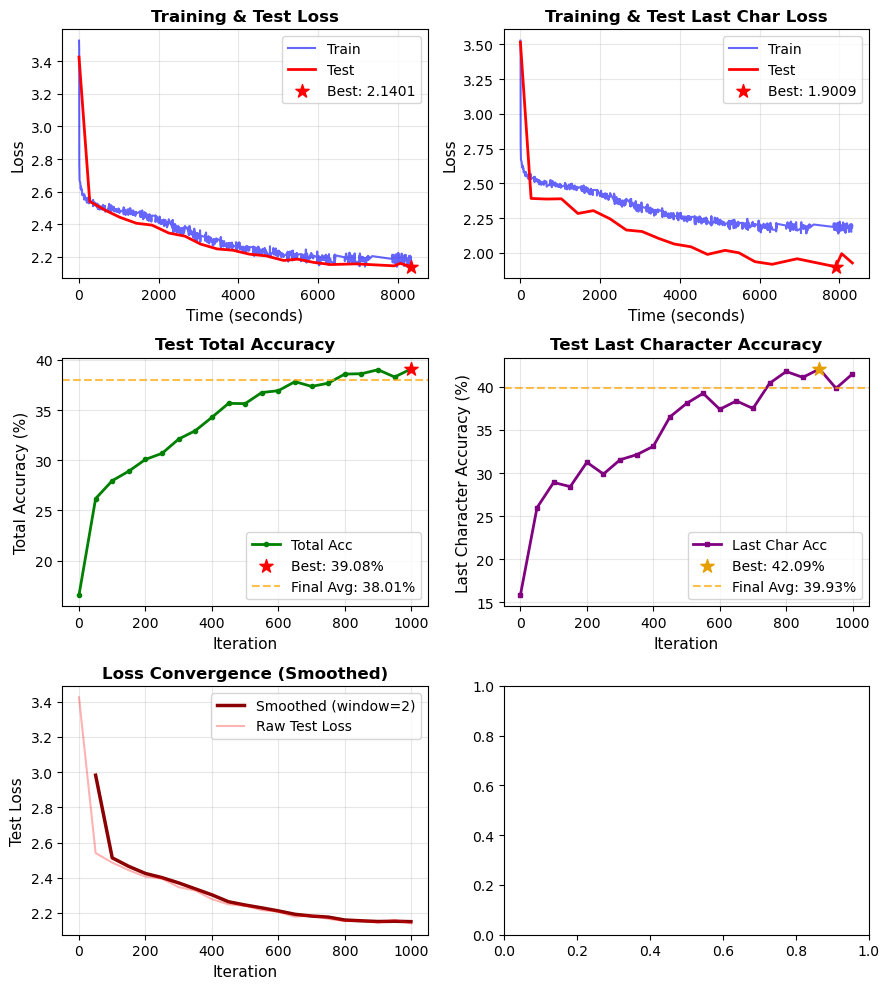

In [50]:
plot_training_curves(
    time_history=time_history,
    loss_history=loss_history,
    time_test_history=time_test_history,
    loss_test_history=loss_test_history,
    loss_last_test_history=loss_last_test_history,
    iteration_history=iteration_history,
    acc_test_history=acc_test_history,
    acc_last_test_history=acc_last_test_history,
    save_path=str(results_dir / 'training_curves.pdf')
)

## Evaluate

In [ ]:
# self-BLEU evaluation
from utils.eval import self_bleu
import json

prompt = "hello my fri"
gen_len = 1000
temperature = 0.7
sample = True
seed = 4212

checkpoint_types = [
    ('best_loss_', 'Best Loss'),
    ('best_loss_last_', 'Best Last-Character Loss'),
    ('best_acc_total_', 'Best Accuracy'),
    ('best_acc_last_', 'Best Last-Char Accuracy'),
    ('stage_1_', 'Mid Epoch')
]

# NEW: how many samples to estimate diversity
num_samples = 20

for prefix, name in checkpoint_types:
    print(f"\n{name}...")

    try:
        ckpt = checkpoints.restore_checkpoint(
            ckpt_dir=str(BEST_DIR),
            target=None,
            prefix=prefix
        )
        if 'stage' in prefix:
            ckpt = checkpoints.restore_checkpoint(
                ckpt_dir=str(STAGE_DIR),
                target=None,
                prefix=prefix
            )

        rng = jax.random.PRNGKey(seed)
        prompt_int = jnp.array(
            [[char_to_int.get(c, len(char_set)) for c in prompt.lower()[:config.model.max_len]]],
            dtype=jnp.int32
        )

        out_ids = generation.generate_tokens(
            model, ckpt['params'], rng, prompt_int, gen_len,
            block_size=config.model.max_len,
            temperature=temperature,
            sample=sample
        )

        generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
        full_text = prompt + generated_text

        filename = prefix.replace('_', '') + '.txt'
        output_path = results_dir / filename

        with open(output_path, 'w') as f:
            f.write(f"{name}\n")
            f.write(f"Step: {ckpt['step']}\n")
            f.write(f"Test Loss: {ckpt['test_loss']:.4f}\n")
            f.write(f"Test Acc: {100*ckpt['test_acc']:.2f}%\n\n")
            f.write(full_text)

        print(f"\tSaved to {output_path}")
        print(f"\tPreview: {full_text[:100]}...")


        # NEW: Self-BLEU evaluation
        rng_base = jax.random.PRNGKey(seed)
        keys = jax.random.split(rng_base, num_samples)

        continuations = []
        for k in keys:
            out_ids_i = generation.generate_tokens(
                model, ckpt['params'], k, prompt_int, gen_len,
                block_size=config.model.max_len,
                temperature=temperature,
                sample=sample
            )
            cont_i = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids_i[0])).strip()
            continuations.append(cont_i)
        tokenized = [c.split() for c in continuations]

        sb = self_bleu(tokenized)

        # Save a small separate metrics JSON
        metrics_path = results_dir / (prefix.replace('_', '') + '_metrics.json')
        metrics = {
            "checkpoint": name,
            "prefix": prefix,
            "step": int(ckpt.get("step", -1)),
            "test_loss": float(ckpt.get("test_loss", float("nan"))),
            "test_acc": float(ckpt.get("test_acc", float("nan"))),
            "num_samples": num_samples,
            "temperature": temperature,
            "sample": sample,
            "gen_len": gen_len,
            "self_bleu": float(sb),
        }
        with open(metrics_path, 'w') as f:
            json.dump(metrics, f, indent=2)

        print(f"\tSelf-BLEU (N={num_samples}): {sb:.6f}")
        print(f"\tSaved metrics to {metrics_path}")

    except Exception as e:
        print(f"\tError: {e}")

In [53]:
prompt = "hello my fri"
gen_len = 1000
temperature = 0.7
sample = True
seed = 4212

checkpoint_types = [
    ('best_loss_', 'Best Loss'),
    ('best_loss_last_', 'Best Last-Character Loss'),
    ('best_acc_total_', 'Best Accuracy'),
    ('best_acc_last_', 'Best Last-Char Accuracy'),
    ('stage_1_', 'Mid Epoch')
]

for prefix, name in checkpoint_types:
    print(f"\n{name}...")

    try:
        # load checkpoint
        ckpt = checkpoints.restore_checkpoint(
            ckpt_dir=str(BEST_DIR),
            target=None,
            prefix=prefix
        )
        if 'stage' in prefix:
            ckpt = checkpoints.restore_checkpoint(
                ckpt_dir=str(STAGE_DIR),
                target=None,
                prefix=prefix
            )
        # generate text
        rng = jax.random.PRNGKey(seed)
        prompt_int = jnp.array(
            [[char_to_int.get(c, len(char_set)) for c in prompt.lower()[:config.model.max_len]]],
            dtype=jnp.int32
        )

        out_ids = generation.generate_tokens(
            model, ckpt['params'], rng, prompt_int, gen_len,
            block_size=config.model.max_len,
            temperature=temperature,
            sample=sample
        )

        generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
        full_text = prompt + generated_text

        # save to file
        filename = prefix.replace('_', '') + '.txt'
        output_path = results_dir / filename

        with open(output_path, 'w') as f:
            f.write(f"{name}\n")
            f.write(f"Step: {ckpt['step']}\n")
            f.write(f"Test Loss: {ckpt['test_loss']:.4f}\n")
            f.write(f"Test Acc: {100*ckpt['test_acc']:.2f}%\n\n")
            f.write(full_text)

        print(f"\tSaved to {output_path}")
        print(f"\tPreview: {full_text[:100]}...")

    except Exception as e:
        print(f"\tError: {e}")


Best Loss...
	Saved to D:\Users\peter\Desktop\DSA4212\CharacterLLM\runs\Baseline\bestloss.txt
	Preview: hello my frinent is this is adits of the four lisof the sere hat with ctich ssoled this to parice of...

Best Last-Character Loss...
	Saved to D:\Users\peter\Desktop\DSA4212\CharacterLLM\runs\Baseline\bestlosslast.txt
	Preview: hello my frinent is this is adits of the four lisof the sere hat with ctich ssoled this to parice of...

Best Accuracy...
	Saved to D:\Users\peter\Desktop\DSA4212\CharacterLLM\runs\Baseline\bestacctotal.txt
	Preview: hello my frinent is this is adits of the four lisof the sere hat with ctich ssoled this to parice of...

Best Last-Char Accuracy...
	Saved to D:\Users\peter\Desktop\DSA4212\CharacterLLM\runs\Baseline\bestacclast.txt
	Preview: hello my frinent is this is adits of the four lisof the sere hat with ctich ssoled this to parice of...

Mid Epoch...
	Saved to D:\Users\peter\Desktop\DSA4212\CharacterLLM\runs\Baseline\stage1.txt
	Preview: hello my frinent 